In [16]:
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
sns.set_style('whitegrid')
from sklearn.metrics import confusion_matrix , classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Flatten , Conv2D , MaxPooling2D , Dropout , Activation , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.applications import EfficientNetB0
import warnings
warnings.filterwarnings('ignore')

In [17]:
import os
data='/kaggle/input/plantvillage-dataset/color'

def create_dataframe(data_path):
    # List to store filepaths and labels
    filepaths = []
    labels = []

    # List all subfolders in the current data path
    folds = os.listdir(data_path)
    
    # Iterate through each subfolder
    for fold in folds:
        f_path = os.path.join(data_path, fold)
        imgs = os.listdir(f_path)
        
        # Iterate through images in the subfolder
        for img in imgs:
            img_path = os.path.join(f_path, img)
            
            # Append image path and corresponding label
            filepaths.append(img_path)
            labels.append(fold)

    # Create Pandas Series for filepaths and labels
    fseries = pd.Series(filepaths, name='Filepaths')
    lseries = pd.Series(labels, name='Labels')

    # Concatenate into a DataFrame and return
    return pd.concat([fseries, lseries], axis=1)

# Create DataFrames for train, test, and val
df = create_dataframe(data)

In [18]:
from sklearn.model_selection import train_test_split
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 42)
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 42)

In [19]:
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for validation and test
test_datagen = ImageDataGenerator(rescale=1./255)

# Create flow_from_dataframe generators for train, validation, and test
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    shuffle=True,
    seed=42
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # No need to shuffle validation data
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # No need to shuffle test data
)

Found 43444 validated image filenames belonging to 38 classes.
Found 5430 validated image filenames belonging to 38 classes.
Found 5431 validated image filenames belonging to 38 classes.


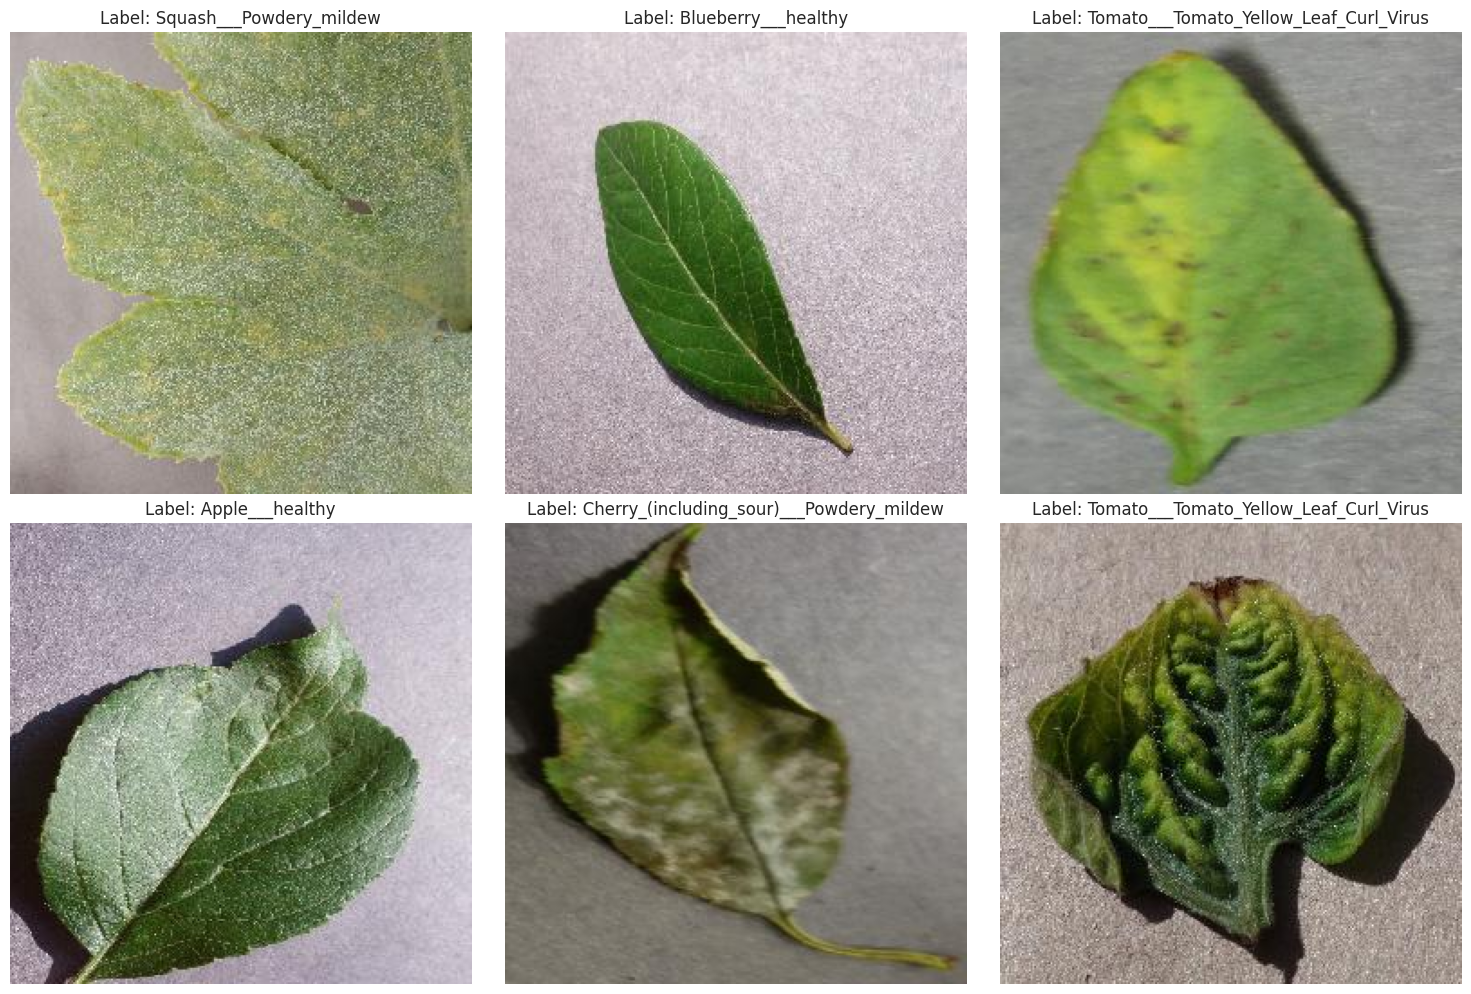

In [20]:
import random

# Function to plot images with their labels
def plot_samples(df, num_samples=6):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        # Randomly select an image
        rand_idx = random.randint(0, len(df) - 1)
        img_path = df.iloc[rand_idx]['Filepaths']
        label = df.iloc[rand_idx]['Labels']
        
        # Read and plot the image
        img = plt.imread(img_path)
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(f'Label: {label}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the function to plot 6 random samples
plot_samples(train_df)

In [21]:
for data_batch, label_batch in train_generator:
    print(f"Data batch shape: {data_batch.shape}")
    print(f"Label batch shape: {label_batch.shape}")
    break

Data batch shape: (32, 224, 224, 3)
Label batch shape: (32, 38)


In [22]:
num_classes = train_df['Labels'].nunique()
print(num_classes)

38


In [23]:
pip install --upgrade tensorflow

Note: you may need to restart the kernel to use updated packages.


In [24]:
base_model2 = EfficientNetB0(weights= 'imagenet' ,include_top = False , input_shape = (224,224,3) ,
                                                     pooling = 'max' )

In [25]:
model2 = Sequential([
    base_model2,
    BatchNormalization(),
    Dense(256,activation = 'relu'),
    Dropout(.5),
    Dense(128, activation='relu' ),
    Dropout(0.5),
    Dense(38 , activation= 'softmax' )
])

In [26]:
model2.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy' , metrics= ['accuracy'])

In [ ]:
history = model2.fit(
    train_generator,
    validation_data=valid_generator,
    epochs= 5 ,
    verbose = 1 ,
    validation_steps= None,
    shuffle= False
   )

Epoch 1/5
   1/1358 ━━━━━━━━━━━━━━━━━━━━ 28:35:05 76s/step - accuracy: 0.0312 - loss: 5.0601

W0000 00:00:1725202658.863160      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.5572 - loss: 1.7720

W0000 00:00:1725203239.231166      97 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725203244.908197      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 682s 446ms/step - accuracy: 0.5573 - loss: 1.7714 - val_accuracy: 0.9593 - val_loss: 0.1451
Epoch 2/5


W0000 00:00:1725203264.808961      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 958/1358 ━━━━━━━━━━━━━━━━━━━━ 2:48 421ms/step - accuracy: 0.9171 - loss: 0.3044

In [ ]:
model2.save('plant_disease_model.h5')